In [1]:
# 설정

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 7.1 투표 기반 분류기

In [3]:
# 동전의 앞면과 뒷면

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1, 10001).reshape(-1, 1)

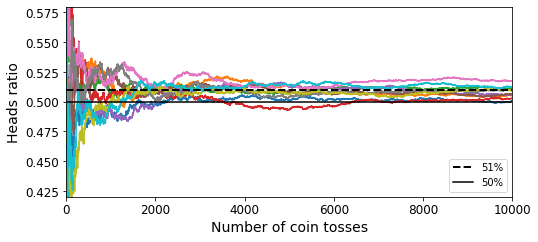

In [5]:
# <그림 7-3. 큰 수의법칙> 생성 코드

plt.figure(figsize = (8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth = 2, label = "51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label = "50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc = "lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [6]:
# moons 데이터셋을 사용해 본다.

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [8]:
# 분류기 여러 개 만들기

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### 간접투표

In [12]:
log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", probability = True, random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [13]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92
